In [45]:
import cv2
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math


In [31]:
img = cv2.imread("data_raw/image/20224869/20224869_Head facing forward_27.551719198255583_51.jpg")

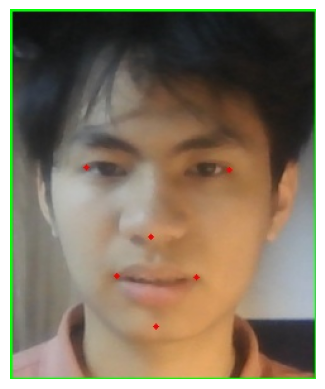

In [32]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img) # RGB

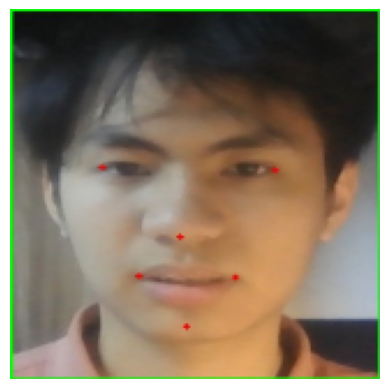

In [33]:
img = cv2.resize(img, (160, 160))
plt.axis('off')
plt.imshow(img)

In [52]:
class FaceLoading:
    def __init__(self,directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.X = []
        self.y = []
    def extract_face(self,path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        face = cv2.resize(img, self.target_size)
        return face
    def load_face_and_class(self):
        for sub_dir in os.listdir(self.directory):
            sub_dir_path = os.path.join(self.directory, sub_dir)
            for img_name in os.listdir(sub_dir_path):
                face = self.extract_face(os.path.join(sub_dir_path, img_name))
                self.X.append(face)
                self.y.append(sub_dir)
        return np.array(self.X), np.array(self.y)
    def plot_images(self):
        num_columns = 3
        num_rows = math.ceil(len(self.X) / num_columns)  # Ensure row count covers all images

        plt.figure(figsize=(num_columns * 3, num_rows * 3))  # Adjust figure size dynamically
        for num, img in enumerate(self.X):
            plt.subplot(num_rows, num_columns, num + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.tight_layout()  # Improve layout spacing
        plt.show()


In [53]:
face_loading = FaceLoading(r"C:\Users\admin\OneDrive - Hanoi University of Science and Technology\Documents\GitHub\PTTK\face_recognization\source\data_raw\image")
X,y = face_loading.load_face_and_class()

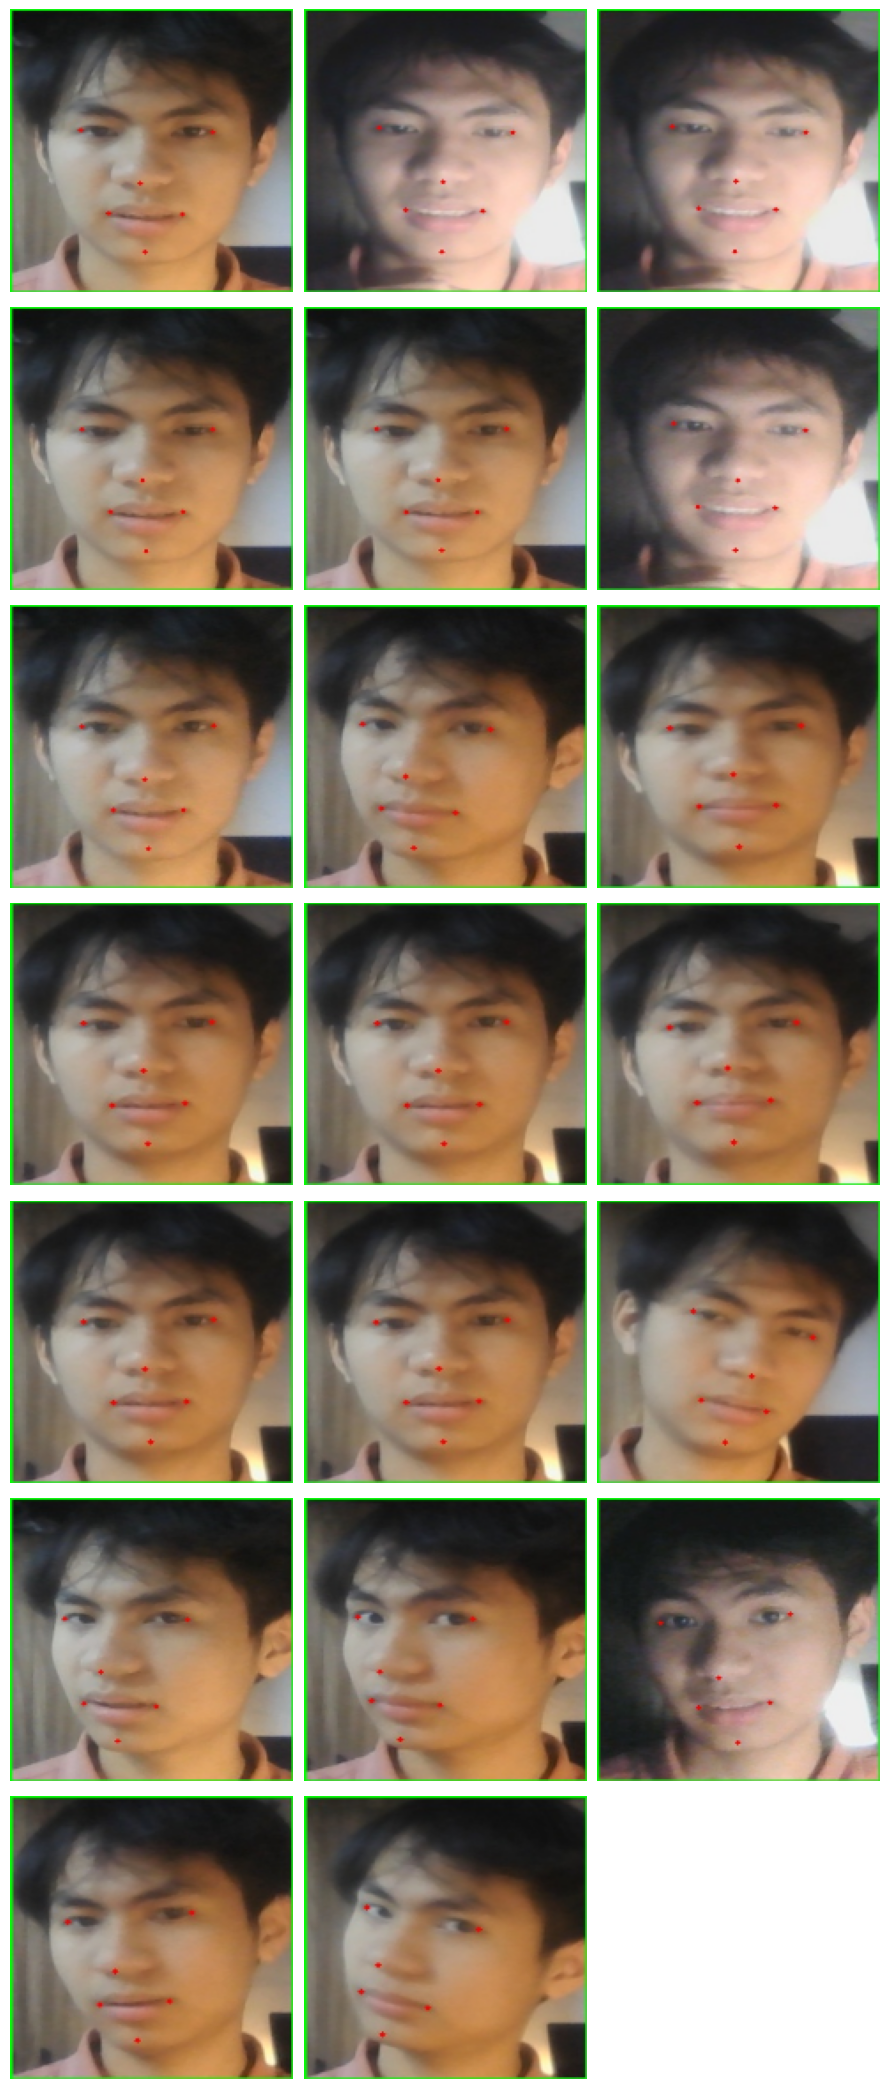

In [54]:
face_loading.plot_images()

In [56]:
len(y),print(y)

['20224869' '20224869' '20224869' '20224869' '20224869' '20224869'
 '20224869' '20224869' '20224869' '20224869' '20224869' '20224869'
 '20224869' '20224869' '20224869' '20224869' '20224869' '20224869'
 '20224869' '20224869']


(20, None)

In [58]:
from keras_facenet import FaceNet
embeder = FaceNet()

In [59]:
def get_embedding(face_img):
    face_img = face_img.astype('float32')
    face_img = tf.expand_dims(face_img, axis=0)
    yhat = embeder.embeddings(img)
    return yhat[0]

In [64]:
EMBEDDED_X = []
for face in X:
    embedding = get_embedding(face)
    EMBEDDED_X.append(embedding)
EMBEDDED_X = np.array(EMBEDDED_X)
# face_img = tf.expand_dims(X[0], axis=0)
# print(face_img.shape)


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 160, 160), dtype=float32). Expected shape (None, None, None, 3), but input has incompatible shape (32, 160, 160)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(32, 160, 160), dtype=float32)
  • training=False
  • mask=None

In [57]:
from sklearn.preprocessing import LabelEncoder
encode =  LabelEncoder()
encoded_y = encode.fit_transform(y)
print(encoded_y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
